## Importing the libraries

In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "cpu"

## Load the dataset

In [2]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets(partition_id: int):
    #Load the cifar-10 dataset while partitioning it into num_clients parts
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})

    #find the partition corresponding to partition_id
    partition = fds.load_partition(partition_id)
    
    #Split partition into training and test set
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    #Apply transformation to partition_train_test for better training results
    #toTensor converts in range [0, 1] while normalize converts in range [-1, 1]
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    #Retrieve the training, validation and test dataset
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )

    return trainloader, valloader, testloader

c:\Users\Mridul\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


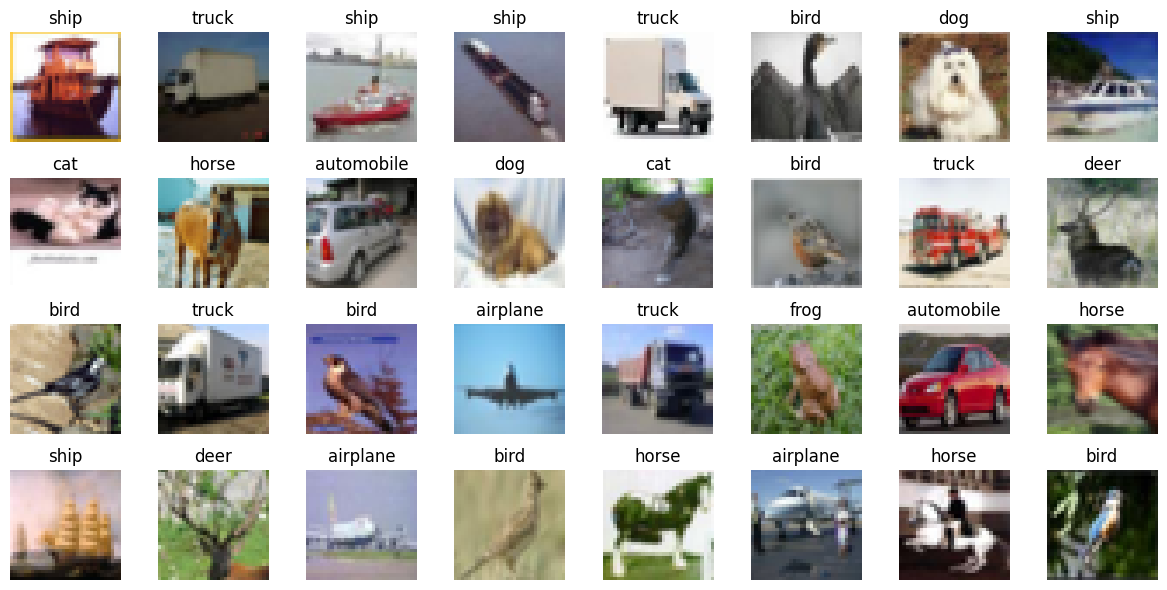

In [3]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# matplotlib expects images to be in (B, H, W, C) format while pytorch returns in (B, C, H, W) format
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5 

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

## Centralized Training


### Define the model

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(net, trainloader, verbose=False):    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    correct, total, epoch_loss = 0, 0, 0.0

    for batch in trainloader:
        images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
        optimizer.zero_grad()
        outputs = net(images)

        loss = criterion(outputs, labels)

        # Update model parameters
        loss.backward()
        optimizer.step()
            
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            
    epoch_loss /= len(trainloader.dataset)
    epoch_acc = correct / total

    if verbose:
        print(f"train loss {epoch_loss}, accuracy {epoch_acc}")

    return epoch_loss, epoch_acc


def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Train the model 

In [6]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    trainLoss, trainAccuracy = train(net, trainloader)
    valLoss, valAccuracy = test(net, valloader)

    train_losses.append(trainLoss)
    train_accuracies.append(trainAccuracy)

    val_losses.append(valLoss)
    val_accuracies.append(valAccuracy)
    
    print(f"Epoch: {epoch+1}")
    print(f"train loss {trainLoss}, accuracy {trainAccuracy}")
    print(f"validation loss {valLoss}, accuracy {valAccuracy}\n")

loss, accuracy = test(net, testloader)
print(f"\nFinal test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch: 1
train loss 0.06581204470992089, accuracy 0.2055
validation loss 0.05960935890674591, accuracy 0.301

Epoch: 2
train loss 0.05745795646309853, accuracy 0.31275
validation loss 0.05593546903133392, accuracy 0.363

Epoch: 3
train loss 0.05409003314375877, accuracy 0.35675
validation loss 0.05417113351821899, accuracy 0.384

Epoch: 4
train loss 0.051885475784540176, accuracy 0.38975
validation loss 0.051395708799362186, accuracy 0.42

Epoch: 5
train loss 0.04998819708824158, accuracy 0.41175
validation loss 0.05078197240829468, accuracy 0.412


Final test set performance:
	loss 0.051425469398498534
	accuracy 0.4015


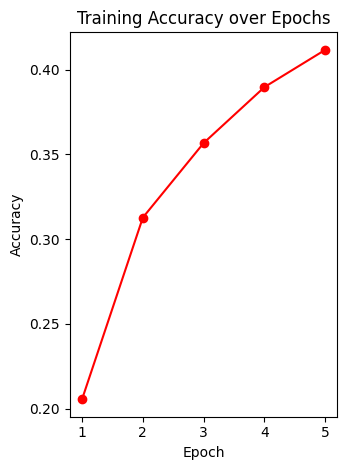

In [7]:
# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), train_accuracies, marker='o', linestyle='-', color='r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")


plt.tight_layout()
plt.show()

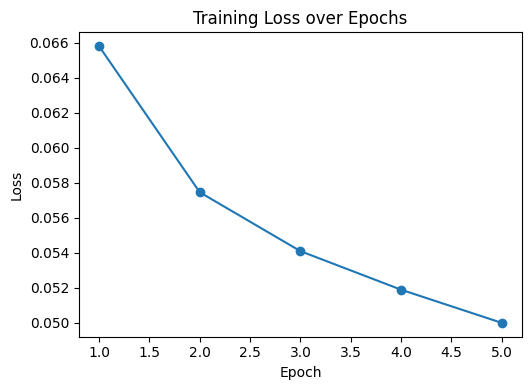

In [8]:
# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), train_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")

plt.tight_layout()
plt.show()

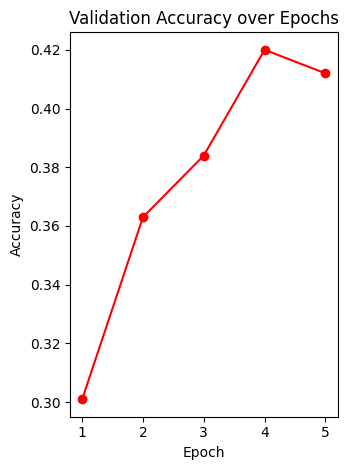

In [9]:
# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), val_accuracies, marker='o', linestyle='-', color='r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")


plt.tight_layout()
plt.show()

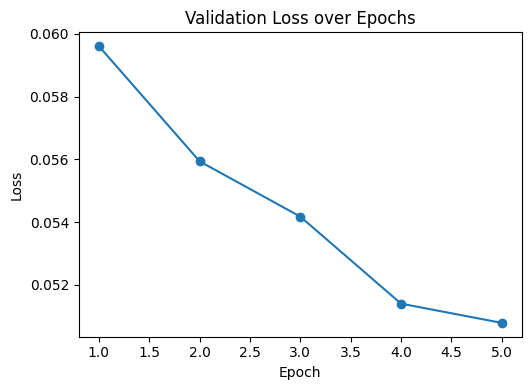

In [10]:
# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), val_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")

plt.tight_layout()
plt.show()


## Federated Learning with Flower

### Update Model Parameter

In [11]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### Define the client

In [12]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = train(self.net, self.trainloader)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [13]:
# client_fn is used to make a Flower client only upon need and then discard it
def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client() to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Define the server

In [14]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [15]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)

## Training

In [16]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

In [17]:
import os
import tensorflow as tf
import warnings
import logging

# Suppress all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="datasets.utils._dill")  
warnings.simplefilter("ignore", DeprecationWarning) 

# Suppress all info & warning messages (only errors remain)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.get_logger().setLevel("ERROR")


# Suppress Ray logs
logging.getLogger("ray").setLevel(logging.ERROR)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=23828) c:\Users\Mridul\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=23828)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=24428) c:\Users\Mridul\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=24428)   obj.co_lnotab,  # for < python 3.10 [